In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import time

from sklearn.metrics import r2_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from IPython.display import Image
import tensorflow as tf

from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, LSTM, SimpleRNN, GRU, Input, Embedding, concatenate
from keras.utils import np_utils, to_categorical, plot_model
from keras.callbacks import ModelCheckpoint, TensorBoard, \
    LearningRateScheduler
from keras.layers.wrappers import TimeDistributed
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l2
from keras.backend.tensorflow_backend import set_session
from keras.preprocessing.sequence import pad_sequences
from keras.datasets import mnist
from keras.layers.core import RepeatVector

# import wrapper_data as wd
# import lstm_wrapper as lw

Using TensorFlow backend.


## Stacking RNNs

In [6]:
# Only have to specify input_shape at the initial layer
# Single scalar output
timesteps = 100
features = 3
model = Sequential()
model.add(LSTM(64, input_shape=(timesteps, features), return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1))

# Scalar output every timestep
model2 = Sequential()
model2.add(LSTM(64, input_shape=(timesteps, features), return_sequences=True))
model2.add(LSTM(64, return_sequences=True),)
model2.add(TimeDistributed(Dense(1)))

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100, 64)           17408     
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 50,497.0
Trainable params: 50,497
Non-trainable params: 0.0
_________________________________________________________________


In [9]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 100, 64)           17408     
_________________________________________________________________
lstm_12 (LSTM)               (None, 100, 64)           33024     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 100, 1)            65        
Total params: 50,497.0
Trainable params: 50,497
Non-trainable params: 0.0
_________________________________________________________________


## Unequal length sequences

In [ ]:
# Pad sequences with zeros to have equal sizes
padded_sequences = pad_sequences(list_of_sequences)

# Add a masking layer
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(timesteps, features)))
model.add(LSTM(32))

## Keras in Tensorflow

* tf.contrib.keras

# One-to-many

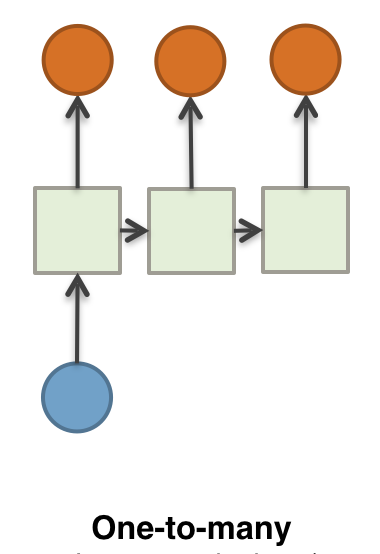

In [2]:
from IPython.display import Image
Image(filename="/src/keras/Gerome/01_main/95_keras_practice/one_to_many.png", height=200, width=200) 

In [42]:
# This model will encode an image into a vector.
vision_model = Sequential()
vision_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
vision_model.add(Conv2D(64, (3, 3), activation='relu'))
vision_model.add(MaxPooling2D((2, 2)))
vision_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
vision_model.add(Conv2D(128, (3, 3), activation='relu'))
vision_model.add(MaxPooling2D((2, 2)))
vision_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
vision_model.add(Conv2D(256, (3, 3), activation='relu'))
vision_model.add(Conv2D(256, (3, 3), activation='relu'))
vision_model.add(MaxPooling2D((2, 2)))
vision_model.add(Flatten())
vision_model.add(Dense(4096, activation='relu'))

# Tensor with the output of vision model:
image_input = Input(shape=(224, 224, 3))
encoded_image = vision_model(image_input)
repeat_encoded_img = RepeatVector(100)(encoded_image)

In [41]:
# Sentence encoding model
sentence_input = Input(shape=(100,), dtype='int32')
embedded_question = Embedding(input_dim=10000, output_dim=256, input_length=100)(sentence_input)
encoded_question = LSTM(256, return_sequences=True)(embedded_question)

In [27]:
# Merge both image features and sentences
merged = concatenate([encoded_question, repeat_encoded_img])
lstm_layer = LSTM(256, return_sequences=True)(merged)

# Logistic regression over 1000 words on top:
output = TimeDistributed(Dense(1000, activation='softmax'))(lstm_layer)

# This is our final model:
image_captioning_model = Model(inputs=[image_input, sentence_input], outputs=output)

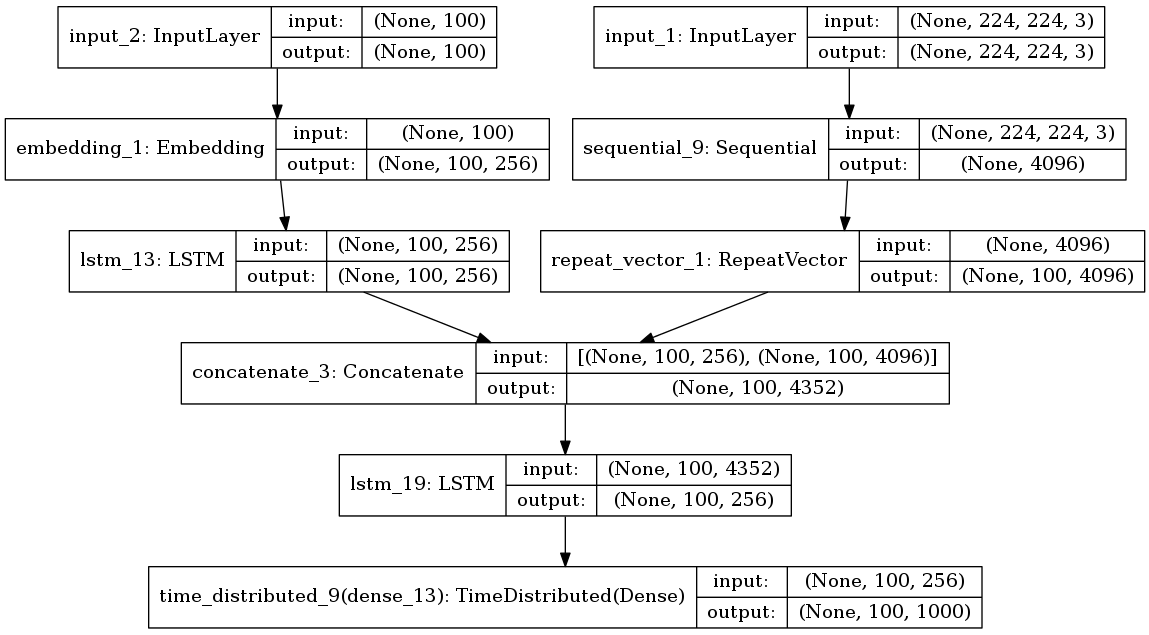

In [36]:
model_img_path = '/src/keras/Gerome/01_main/95_keras_practice/RNN_image_captioning_model.png'
plot_model(image_captioning_model, to_file=model_img_path, show_shapes=True)
Image(model_img_path)

### Character to Character Generation

In [1]:
import numpy as np
import os
import sys

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.models import load_model

# Load text and convert to lowercase
filename = "input.txt"
with open(filename) as raw_text:
    raw_text = raw_text.read()
    raw_text = raw_text.lower()

Using TensorFlow backend.


In [2]:
# Mapping of characters to integers
chars_list = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars_list))
int_to_char = dict((i, c) for i, c in enumerate(chars_list))

In [3]:
# Summary of loaded text
n_chars = len(raw_text)
n_vocab = len(chars_list)
print("Total number of characters: ", n_chars)
print("Total length of vocabulary: ", n_vocab)

Total number of characters:  1115394
Total length of vocabulary:  39


In [5]:
# Cut text to sequences of length 100
seq_length = 100
data_X = [] # input X
data_Y = [] # target y
for i in range(0, n_chars - seq_length):
    seq_in = raw_text[i:i + seq_length]
    seq_out = raw_text[i + seq_length]
    data_X.append([char_to_int[char] for char in seq_in])
    data_Y.append(char_to_int[seq_out])
n_patterns = len(data_X)
print("Total numebr of sequences: {}".format(n_patterns))

Total numebr of sequences: 1115294


In [6]:
# Reshape data X to shape [samples, time steps, features]
X = np.reshape(data_X, (n_patterns, seq_length, 1))

# Normalize
X = X / float(n_vocab)

# One hot encoding of target y
y = np_utils.to_categorical(data_Y)
print("X shape is ==> {}".format(X.shape))
print("y shape is ==> {}".format(y.shape))

X shape is ==> (1115294, 100, 1)
y shape is ==> (1115294, 39)


In [7]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(512))
# model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [60]:
# Define some checkpointers
fpath = "shakespeare_model.hdf5"
checkpoint = ModelCheckpoint(fpath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# Train model
model.fit(X, y, epochs=20, batch_size=3200, callbacks=callbacks_list)

Epoch 1/20
5458099/5458099 [==============================] - 644s - loss: 2.6915   
Epoch 2/20
 150400/5458099 [..............................] - ETA: 636s - loss: 2.5539

KeyboardInterrupt: 

In [8]:
# List of pretrained models
models_list = [os.path.join("./rnn_shakespeare/", i) for i in os.listdir("./rnn_shakespeare/") if 'model2' in i]
models_list.sort()
models_list

['./rnn_shakespeare/final_model2-00-2.6566.hdf5',
 './rnn_shakespeare/final_model2-01-2.0642.hdf5',
 './rnn_shakespeare/final_model2-02-1.8161.hdf5',
 './rnn_shakespeare/final_model2-03-1.6845.hdf5',
 './rnn_shakespeare/final_model2-04-1.5947.hdf5',
 './rnn_shakespeare/final_model2-05-1.5298.hdf5',
 './rnn_shakespeare/final_model2-06-1.4766.hdf5',
 './rnn_shakespeare/final_model2-07-1.4366.hdf5',
 './rnn_shakespeare/final_model2-08-1.4013.hdf5',
 './rnn_shakespeare/final_model2-09-1.3735.hdf5',
 './rnn_shakespeare/final_model2-10-1.3437.hdf5',
 './rnn_shakespeare/final_model2-11-1.3206.hdf5',
 './rnn_shakespeare/final_model2-12-1.3009.hdf5',
 './rnn_shakespeare/final_model2-13-1.2799.hdf5',
 './rnn_shakespeare/final_model2-14-1.2637.hdf5',
 './rnn_shakespeare/final_model2-15-1.2445.hdf5',
 './rnn_shakespeare/final_model2-16-1.2288.hdf5',
 './rnn_shakespeare/final_model2-17-1.2116.hdf5',
 './rnn_shakespeare/final_model2-18-1.1982.hdf5',
 './rnn_shakespeare/final_model2-19-1.1816.hdf5']

In [41]:
# Load weights of pretrained model
load_fname = models_list[0]
model.load_weights(load_fname)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [118]:
np.random.seed(500)
start = np.random.randint(0, len(data_X)-1)
pattern = data_X[start][:100]
print("\"", ''.join([int_to_char[value] for value in pattern]), "\"")

" r:
sir, his stoutness
when he did stand for consul, which he lost
by lack of stooping,--

aufidius:
 "


In [99]:
# Generate characters
def generate_txt(model_id, pattern_in):
    '''
    Generate txt given a model
    '''
    # Load weights of pretrained model
    pattern_in = pattern_in.copy()
    load_fname = models_list[model_id]
    model.load_weights(load_fname)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
#     # Pick random a sequence
#     np.random.seed(random_seed)
#     start = np.random.randint(0, len(data_X)-1)
#     pattern = data_X[start]
    print("START_GENERATION++")
#     print("\"", ''.join([int_to_char[value] for value in pattern]), "\"", end='')
    print(''.join([int_to_char[value] for value in pattern_in]), end='')

    for i in range(100):
        # X shape (1,100,1)
        x = np.reshape(pattern_in, (1, len(pattern_in), 1))
        x = x / float(n_vocab)

        # Output shape (1,65)
        prediction = model.predict(x, verbose=0)

        # Predicted character
        index = np.argmax(prediction)
        result = int_to_char[index]
        seq_in = [int_to_char[value] for value in pattern_in]
        print(result, end='')
    #     sys.stdout.write(result)
        pattern_in.append(index)
        pattern_in = pattern_in[1:len(pattern_in)]
    #     print('a', end='')
    print("\n++END_GENERATION.")

In [119]:
generate_txt(0, pattern)

START_GENERATION++
r:
sir, his stoutness
when he did stand for consul, which he lost
by lack of stooping,--

aufidius:
i would the sooe the sooe to the sooe the sooe to the sooe the sooe the sooe the sooe the sooe the s
++END_GENERATION.


In [120]:
generate_txt(5, pattern)

START_GENERATION++
r:
sir, his stoutness
when he did stand for consul, which he lost
by lack of stooping,--

aufidius:
i will not be mothing bome to the sower.

bamillo:
i will not be mothing but that the suate of the s
++END_GENERATION.


In [121]:
generate_txt(10, pattern)

START_GENERATION++
r:
sir, his stoutness
when he did stand for consul, which he lost
by lack of stooping,--

aufidius:
why, then the sest is not to be a season that i have some spet and the sest of thee,
the sest i have
++END_GENERATION.


In [122]:
generate_txt(-1, pattern)

START_GENERATION++
r:
sir, his stoutness
when he did stand for consul, which he lost
by lack of stooping,--

aufidius:
i will not speak.

petruchio:
what is the matter?

coriolanus:
what is the matter?

coriolanus:
what
++END_GENERATION.
